In [ ]:
import pandas as pd
pd.set_option('max_columns',100)
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

### 
1. Core business problem being solved - 
2. who is the stakeholder - Underwriters, Claim Department, CFO, 
3. Business metric - 
4. Data Science Problem / Data sci metric - 
5. EDA Questions important for Stakeholder
6. Simple Model
7. Feature Selection
8. Feature Engg

Questions - Claim column purpose: Did the customer apply for the claim or not; or was the claim sanctioned or not.

In [2]:
df = pd.read_csv('../data/train.csv')

NameError: ignored

In [ ]:
df.groupby('Destination').Claim.value_counts(normalize = True).unstack()[1].sort_values(ascending = False)[:5]#.to_csv('eda_question.csv')

Destination
SINGAPORE        0.372560
SOUTH AFRICA     0.333333
NEPAL            0.320312
COSTA RICA       0.250000
UNITED STATES    0.202186
Name: 1, dtype: float64

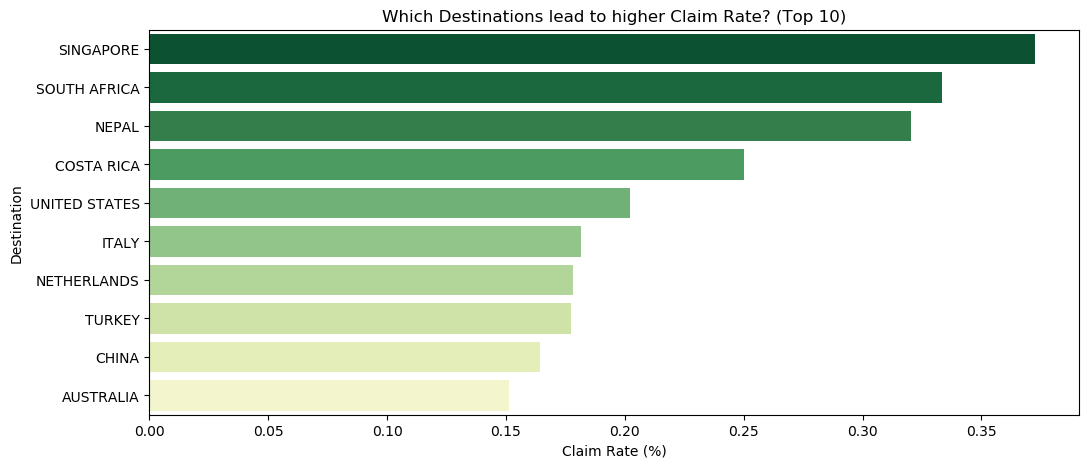

In [ ]:
plt.rcdefaults()
plt.figure(figsize = (12,5))
sns.barplot(x = df.groupby('Destination').Claim.value_counts(normalize = True).unstack()[1].sort_values(ascending = False)[:10].values,
           y = df.groupby('Destination').Claim.value_counts(normalize = True).unstack()[1].sort_values(ascending = False)[:10].index,
           palette = 'YlGn_r')
plt.xlabel('Claim Rate (%)')
plt.title('Which Destinations lead to higher Claim Rate? (Top 10)')
plt.savefig('destination_vs_claims.png',transparent = True, dpi = 300, edgecolor = 'Blue')

In [ ]:
df[['Net Sales','Commision (in value)']].corr()

,Net Sales,Commision (in value)
Net Sales,1.00000,0.73311
Commision (in value),0.73311,1.00000


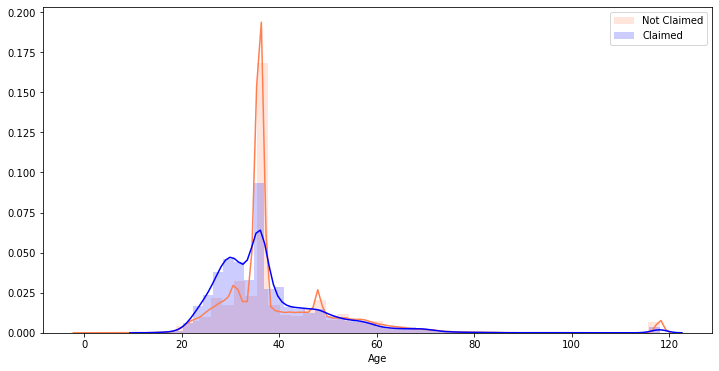

In [ ]:
plt.figure(figsize = (12,6))
sns.distplot(df[df.Claim == 0].Age, color ='coral', label = 'Not Claimed',hist_kws = dict(alpha = 0.2))
sns.distplot(df[df.Claim == 1].Age, color ='blue', label = 'Claimed', hist_kws = dict(alpha = 0.2))
plt.legend()

#### Top products distributed by Claimed/Not Claimed

In [ ]:
round(df.groupby('Claim')['Product Name'].value_counts(normalize = True)*100,2).unstack()

Product Name,1 way Comprehensive Plan,2 way Comprehensive Plan,24 Protect,Annual Gold Plan,Annual Silver Plan,Annual Travel Protect Gold,Annual Travel Protect Platinum,Annual Travel Protect Silver,Basic Plan,Bronze Plan,Cancellation Plan,Child Comprehensive Plan,Comprehensive Plan,Gold Plan,Individual Comprehensive Plan,Premier Plan,Rental Vehicle Excess Insurance,Silver Plan,Single Trip Travel Protect Gold,Single Trip Travel Protect Platinum,Single Trip Travel Protect Silver,Spouse or Parents Comprehensive Plan,Ticket Protector,Travel Cruise Protect,Value Plan
Claim,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.37,20.87,0.38,0.28,2.06,0.14,0.08,0.14,8.71,6.20,29.59,0.02,0.61,0.54,0.11,0.32,13.68,3.39,0.30,0.11,0.26,0.03,1.66,0.86,4.28
1,0.78,16.71,NaN,1.97,16.64,1.38,0.16,0.36,2.82,23.17,4.07,NaN,0.14,1.64,0.42,0.02,9.72,15.87,1.39,0.57,0.18,0.01,0.65,0.24,1.08


# Pre-processing

1. Duration Column: Replace -1 by 0
2. Net Sales: Take absolute of -ve values, find the sqrt, and then add the -ve sign again.


### Dropping Columns

In [ ]:
import time as time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
df = pd.read_csv('data/train.csv')

In [ ]:
df.drop('ID',1,inplace = True)

In [ ]:
columns = df.select_dtypes('object').columns.tolist()
for column in columns:
    df = pd.concat((df,pd.get_dummies(df[column])),1)
    df.drop(column,1,inplace = True)
df

,Duration,Net Sales,Commision (in value),Age,Claim,ADM,ART,C2B,CBH,CCR,CSR,CWT,EPX,JWT,JZI,KML,LWC,RAB,SSI,TST,TTW,Airlines,Travel Agency,Offline,Online,1 way Comprehensive Plan,2 way Comprehensive Plan,24 Protect,Annual Gold Plan,Annual Silver Plan,Annual Travel Protect Gold,Annual Travel Protect Platinum,Annual Travel Protect Silver,Basic Plan,Bronze Plan,Cancellation Plan,Child Comprehensive Plan,Comprehensive Plan,Gold Plan,Individual Comprehensive Plan,Premier Plan,Rental Vehicle Excess Insurance,Silver Plan,Single Trip Travel Protect Gold,Single Trip Travel Protect Platinum,Single Trip Travel Protect Silver,Spouse or Parents Comprehensive Plan,Ticket Protector,Travel Cruise Protect,Value Plan,...,KYRGYZSTAN,LAO PEOPLE'S DEMOCRATIC REPUBLIC,LEBANON,LITHUANIA,LUXEMBOURG,MACAO,MALAYSIA,MALDIVES,MALTA,MAURITIUS,MEXICO,MONGOLIA,MOROCCO,MYANMAR,NEPAL,NETHERLANDS,NEW ZEALAND,NORWAY,OMAN,PAKISTAN,PERU,PHILIPPINES,POLAND,PORTUGAL,QATAR,ROMANIA,RUSSIAN FEDERATION,SAUDI ARABIA,SINGAPORE,SLOVENIA,SOUTH AFRICA,SPAIN,SRI LANKA,SWEDEN,SWITZERLAND,"TAIWAN, PROVINCE OF CHINA","TANZANIA, UNITED REPUBLIC OF",THAILAND,TUNISIA,TURKEY,TURKMENISTAN,UKRAINE,UNITED ARAB EMIRATES,UNITED KINGDOM,UNITED STATES,UZBEKISTAN,VANUATU,VENEZUELA,VIET NAM,ZAMBIA
0,61,12.000000,0.0000,41,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,17.000000,0.0000,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26,19.800000,11.8800,47,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,15,27.000000,0.0000,48,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,37.000000,0.0000,36,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52305,365,444.750593,111.1858,40,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52306,8,23.000000,9.2000,54,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52307,38,61.100000,15.2800,37,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52308,2,10.000000,0.0000,46,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Treating negative values in Duration column
df.Duration.replace(-1,0, inplace = True)
df.Duration.replace(-2,0, inplace = True)

### Managing Skewed columns

In [ ]:
df.loc[:,'Duration'] = np.power(df.Duration, 0.15)

In [ ]:
# Transforming values in Net Sales column
power = 0.25
values = df.index
for index in values:
    if df.loc[index,'Net Sales'] < 0:
        df.loc[index,'Net Sales'] = -np.power(abs(df.loc[index,'Net Sales']), power)
    else:
        df.loc[index,'Net Sales'] = np.power(df.loc[index,'Net Sales'], power)

In [ ]:
df.loc[:,'Commision (in value)'] = np.power(df['Commision (in value)'], 0.3)

In [ ]:
t0 = time.time()
X = df.drop('Claim',1)
y = df.Claim

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0, test_size = 0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state = 0)

model.fit(X_train, y_train)

pred = model.predict(X_test)

t1 = time.time()

print('Time Taken:', t1-t0)
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('Confusion Matrix:', confusion_matrix(y_test, pred))

Time Taken: 8.219114065170288
Accuracy: 0.9386350602179315
Precision: 0.8351648351648352
Recall: 0.7862068965517242
Confusion Matrix: [[8452  270]
 [ 372 1368]]


In [ ]:
t0 = time.time()
X = df.drop('Claim',1)
y = df.Claim

sm = RandomOverSampler(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state = 0, criterion = 'entropy')

model.fit(X_train, y_train)

pred = model.predict(X_test)

t1 = time.time()

print('Time Taken:', t1-t0)
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('Confusion Matrix:', confusion_matrix(y_test, pred))

Time Taken: 19.28461980819702
Accuracy: 0.9772883688919477
Precision: 0.9570538495772141
Recall: 0.9988388295401764
Confusion Matrix: [[4219  193]
 [   5 4301]]


In [ ]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


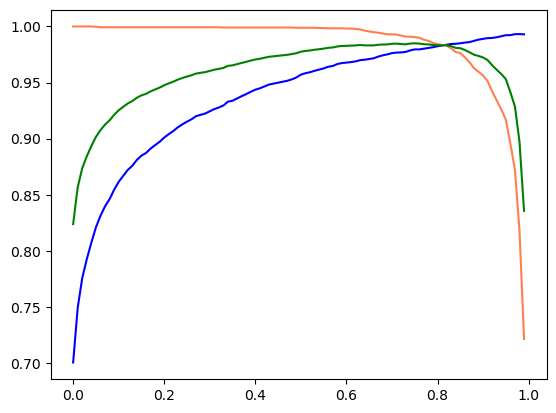

In [ ]:
precision = []
recall = []
f1score = []
for threshold in tqdm(np.array(range(100))/100):
    predictions = model.predict_proba(X_test)[:,1]
    predictions = (predictions > threshold).astype(int)
    
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions)) 
    f1score.append(f1_score(y_test, predictions))

sns.lineplot(x = np.array(range(100))/100, y = precision, color = 'blue')
sns.lineplot(x = np.array(range(100))/100, y = recall,color = 'coral')
sns.lineplot(x = np.array(range(100))/100, y = f1score,color = 'green')

In [ ]:
predictions = model.predict_proba(X_test)[:,1]
predictions = (predictions > 0.98).astype(int)

print(precision_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(f1_score(y_test, predictions))
print(accuracy_score(y_test, predictions))

0.9932318104906938
0.8179284718996749
0.8970962812022415
0.9073181922459279


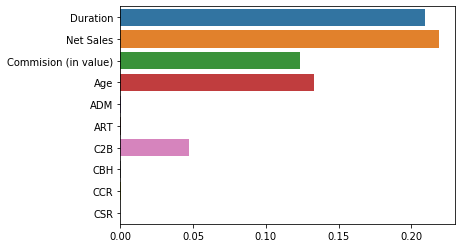

In [ ]:
sns.barplot(x = model.feature_importances_[:10], y = X.columns[:10])

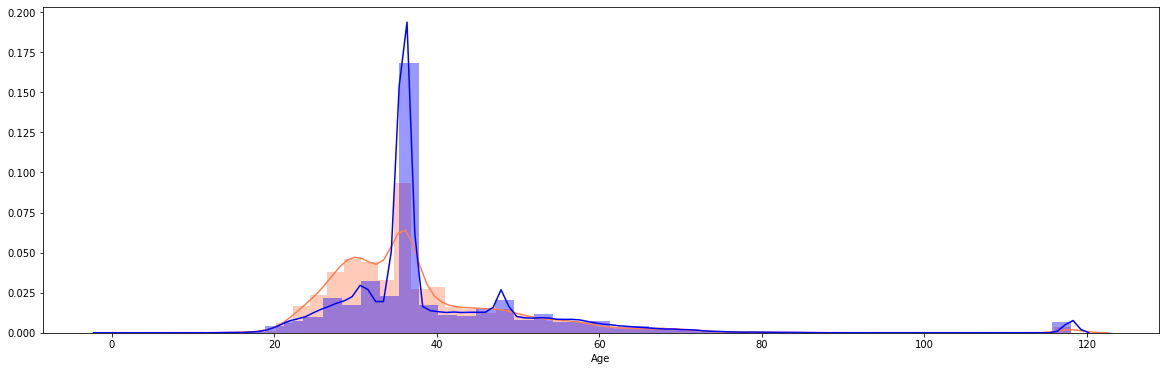

In [ ]:
plt.figure(figsize = (20,6))
sns.distplot(df[df.Claim == 1].Age, color = 'coral')
sns.distplot(df[df.Claim == 0].Age, color = 'blue')

In [ ]:
test = pd.read_csv('data/test.csv')

In [ ]:
test

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,17631,EPX,Travel Agency,Online,Cancellation Plan,192,HONG KONG,18.0,0.00,36
1,15064,EPX,Travel Agency,Online,1 way Comprehensive Plan,2,SINGAPORE,20.0,0.00,36
2,14139,C2B,Airlines,Online,Bronze Plan,13,SINGAPORE,13.5,3.38,24
3,19754,EPX,Travel Agency,Online,2 way Comprehensive Plan,133,"TAIWAN, PROVINCE OF CHINA",41.0,0.00,36
4,16439,C2B,Airlines,Online,Silver Plan,2,SINGAPORE,30.0,7.50,32
...,...,...,...,...,...,...,...,...,...,...
22416,13227,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,10,AUSTRALIA,0.0,11.88,27
22417,12767,EPX,Travel Agency,Online,2 way Comprehensive Plan,32,THAILAND,33.0,0.00,36
22418,13638,EPX,Travel Agency,Online,2 way Comprehensive Plan,5,THAILAND,20.0,0.00,36
22419,14859,EPX,Travel Agency,Online,Cancellation Plan,15,HONG KONG,10.0,0.00,36


In [ ]:
ids = test.ID

### Transforming Test Data

In [ ]:
# Drop ID
test.drop('ID',1,inplace = True)

# One Hot Encoding
columns = test.select_dtypes('object').columns.tolist()
for column in columns:
    test = pd.concat((test,pd.get_dummies(test[column])),1)
    test.drop(column,1,inplace = True)

# Treating negative values in Duration column
test.Duration.replace(-1,0, inplace = True)
test.Duration.replace(-2,0, inplace = True)

# Skewed Columns
test.loc[:,'Duration'] = np.power(test.Duration, 0.15)

power = 0.25
values = test.index
for index in values:
    if test.loc[index,'Net Sales'] < 0:
        test.loc[index,'Net Sales'] = -np.power(abs(test.loc[index,'Net Sales']), power)
    else:
        test.loc[index,'Net Sales'] = np.power(test.loc[index,'Net Sales'], power)       

test.loc[:,'Commision (in value)'] = np.power(test['Commision (in value)'], 0.3)

# Scaler tranformation
test = scaler.transform(test)

# prediction
pred_test = model.predict(test)

# threshold tuned predictions 
predictions = model.predict_proba(test)[:,1]
predictions = (predictions > 0.98).astype(int)

In [ ]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submission = pd.DataFrame()
submission['ID'] = ids
submission['Claim'] = predictions

submission

,ID,Claim
0,17631,0
1,15064,0
2,14139,0
3,19754,0
4,16439,0
...,...,...
22416,13227,0
22417,12767,0
22418,13638,0
22419,14859,0


In [ ]:
submission.to_csv('submission.csv',index = False)